# How to train and deploy Learning To Rank

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/elastic/elasticsearch-labs/blob/main/notebooks/search/08-learning-to-rank.ipynb)

In this notebook, we'll:

- Connect to an Elasticsearch deployment using the official Python client.
- Import and index a movie dataset into Elasticsearch.
- Extract features from our dataset using Elasticsearch's Query DSL, including custom `script_score` queries.
- Build a training dataset by combining extracted features with a human curated judgment list.
- Train a Learning To Rank model using [XGBoost](https://xgboost.ai/).
- Deploy the trained model to Elasticsearch using [Eland](https://eland.readthedocs.io/en/latest/).
- Use the model as a rescorer for second stage re-ranking.
- Evaluate the impact of the LTR model on search relevance, by comparing search results before and after applying the model.

> **NOTE:**
> - Learning To Rank is available for Elastic Stack versions 8.12.0 and newer and requires a Platinum subscription or higher.
> - Learning To Rank is experimental and may be changed or removed completely in future releases. Elastic will make a best effort to fix any issues, but experimental features are not supported to the same level as generally available (GA) features.


## Install required packages

First we must install the packages we need for this notebook.

In [18]:
!pip install -qU elasticsearch eland "eland[scikit-learn]" xgboost tqdm

from tqdm import tqdm

# Setup the progress bar so we can use progress_apply in the notebook.
tqdm.pandas()

## Configure your Elasticsearch deployment

For this example, we will be using an [Elastic Cloud](https://www.elastic.co/guide/en/cloud/current/ec-getting-started.html) deployment (available with a [free trial](https://cloud.elastic.co/registration?utm_source=github&utm_content=elasticsearch-labs-notebook)).

In [ ]:
from getpass import getpass
from elasticsearch import Elasticsearch

# https://www.elastic.co/search-labs/tutorials/install-elasticsearch/elastic-cloud#finding-your-cloud-id
ELASTIC_CLOUD_ID = getpass("Elastic Cloud ID: ")

# https://www.elastic.co/search-labs/tutorials/install-elasticsearch/elastic-cloud#creating-an-api-key
ELASTIC_API_KEY = getpass("Elastic Api Key: ")

# Create the client instance
es_client = Elasticsearch(
    # For local development
    # hosts=["http://localhost:9200"]
    cloud_id=ELASTIC_CLOUD_ID,
    api_key=ELASTIC_API_KEY,
)

### Enable Telemetry

Knowing that you are using this notebook helps us decide where to invest our efforts to improve our products. We would like to ask you that you run the following code to let us gather anonymous usage statistics. See [telemetry.py](https://github.com/elastic/elasticsearch-labs/blob/main/telemetry/telemetry.py) for details. Thank you!

In [ ]:
!curl -O -s https://raw.githubusercontent.com/elastic/elasticsearch-labs/main/telemetry/telemetry.py
from telemetry import enable_telemetry

es_client = enable_telemetry(es_client, "08-learning-to-rank")

### Test the Client
Before you continue, confirm that the client has connected with this test.

In [ ]:
client_info = es_client.info()

f"Successfully connected to cluster {client_info['cluster_name']} (version {client_info['version']['number']})"

## Configure the dataset

We'll use a dataset derived from the [MSRD (Movie Search Ranking Dataset)](https://github.com/metarank/msrd/tree/master).

The dataset is available [here](https://github.com/elastic/elasticsearch-labs/tree/main/notebooks/search/sample_data/learning-to-rank/) and contains the following files:

- `movies_corpus.jsonl.gz`: Movie dataset to be indexed.
- `movies_judgements.tsv.gz`: Judgment list of relevance judgments for a set of queries.
- `movies_index_settings.json`: Settings to be applied to the documents and index.

In [20]:
from urllib.parse import urljoin

DATASET_BASE_URL = "https://raw.githubusercontent.com/elastic/elasticsearch-labs/main/notebooks/search/sample_data/learning-to-rank/"

CORPUS_URL = urljoin(DATASET_BASE_URL, "movies-corpus.jsonl.gz")
JUDGEMENTS_FILE_URL = urljoin(DATASET_BASE_URL, "movies-judgments.tsv.gz")
INDEX_SETTINGS_URL = urljoin(DATASET_BASE_URL, "movies-index-settings.json")

 ## Import the document corpus

This step will import the documents of the corpus into the `movies` index .

Documents contains the following fields:

| Field name   | Description                                 |
|--------------|---------------------------------------------|
| `id`         | Id of the document                          |
| `title`      | Movie title                                 |
| `overview`   | A short description of the movie            |
| `actors`     | List of actors in the movies                |
| `director`   | Director of the movie                       |
| `characters` | List of characters that appear in the movie |
| `genres`     | Genres of the movie                         |
| `year`       | Year the movie was released                 |
| `budget`     | Budget of the movies in USD                 |
| `votes`      | Number of votes received by the movie       |
| `rating`     | Average rating of the movie                 |
| `popularity` | Number use to measure the movie popularity  |
| `tags`       | A list of tags for the movies               |



In [8]:
import json
import elasticsearch.helpers as es_helpers
import pandas as pd
from urllib.request import urlopen

MOVIE_INDEX = "movies"

# Delete index
print("Deleting index if it already exists:", MOVIE_INDEX)
es_client.options(ignore_status=[400, 404]).indices.delete(index=MOVIE_INDEX)

print("Creating index:", MOVIE_INDEX)
index_settings = json.load(urlopen(INDEX_SETTINGS_URL))
es_client.indices.create(index=MOVIE_INDEX, **index_settings)

print(f"Loading the corpus from {CORPUS_URL}")
corpus_df = pd.read_json(CORPUS_URL, lines=True)

print(f"Indexing the corpus into {MOVIE_INDEX} ...")
bulk_result = es_helpers.bulk(
    es_client,
    actions=[
        {"_id": movie["id"], "_index": MOVIE_INDEX, **movie}
        for movie in corpus_df.to_dict("records")
    ],
)
print(f"Indexed {bulk_result[0]} documents into {MOVIE_INDEX}")

Deleting index if it already exists: movies
Creating index: movies
Loading the corpus from https://raw.githubusercontent.com/elastic/elasticsearch-labs/ltr-notebook/notebooks/search/sample_data/learning-to-rank/movies-corpus.jsonl.gz
Indexing the corpus into movies ...
Indexed 9750 documents into movies


## Loading the judgment list

The judgment list contains human evaluations that we'll use to train our Learning To Rank model.

Each row represents a query-document pair with an associated relevance grade and contains the following columns:

| Column    | Description                                                            |
|-----------|------------------------------------------------------------------------|
| `query_id`| Pairs for the same query are grouped together and received a unique id. |
| `query`   | Actual text of the query.                                             |
| `doc_id`  | ID of the document.                                                    |
| `grade`   | The relevance grade of the document for the query.                     |


**Note:**

In this example the relevance grade is a binary value (relevant or not relavant).
You could also use a number that represents the degree of relevance (e.g. from `0` to `4`).

In [34]:
judgments_df = pd.read_csv(JUDGEMENTS_FILE_URL, delimiter="\t")
judgments_df

,query_id,query,doc_id,grade
0,qid:5141,insidious 2 netflix,846433,0
1,qid:5141,insidious 2 netflix,49018,1
2,qid:5141,insidious 2 netflix,38234,0
3,qid:5141,insidious 2 netflix,567604,0
4,qid:5141,insidious 2 netflix,269795,0
...,...,...,...,...
384750,qid:3383,2013 the wolverine,263115,0
384751,qid:3383,2013 the wolverine,25913,0
384752,qid:3383,2013 the wolverine,567604,0
384753,qid:3383,2013 the wolverine,533535,0


## Configure feature extraction

Features are the inputs to our model. They represent information about the query alone, a result document alone, or a result document in the context of a query, such as BM25 scores.

Features are defined using standard templated queries and the Query DSL.

To streamline the process of defining and refining feature extraction during training, we have incorporated a number of primitives directly in `eland`.

In [35]:
from eland.ml.ltr import LTRModelConfig, QueryFeatureExtractor

ltr_config = LTRModelConfig(
    feature_extractors=[
        # For the following field we want to use the score of the match query for the field as a features:
        QueryFeatureExtractor(
            feature_name="title_bm25", query={"match": {"title": "{{query}}"}}
        ),
        QueryFeatureExtractor(
            feature_name="actors_bm25", query={"match": {"actors": "{{query}}"}}
        ),
        # We could also use a more strict matching clause as an additional features. Here we want all the terms of our query to match.
        QueryFeatureExtractor(
            feature_name="title_all_terms_bm25",
            query={
                "match": {
                    "title": {"query": "{{query}}", "minimum_should_match": "100%"}
                }
            },
        ),
        QueryFeatureExtractor(
            feature_name="actors_all_terms_bm25",
            query={
                "match": {
                    "actors": {"query": "{{query}}", "minimum_should_match": "100%"}
                }
            },
        ),
        # Also we can use a script_score query to get the document field values directly as a feature.
        QueryFeatureExtractor(
            feature_name="popularity",
            query={
                "script_score": {
                    "query": {"exists": {"field": "popularity"}},
                    "script": {"source": "return doc['popularity'].value;"},
                }
            },
        ),
    ]
)

## Building the training dataset

Now that we have our basic datasets loaded, and feature extraction configured, we'll use our judgment list to come up with the final dataset for training. The dataset will consist of rows containing `<query, document>` pairs, as well as all of the features we need to train the model. To generate this dataset, we'll run each query from the judgment list and add the extracted features as columns for each of the labelled result documents.

For example, if we have a query `q1` with two labelled documents `d3` and `d9`, the training dataset will end up with two rows — one for each of the pairs `<q1, d3>` and `<q1, d9>`.

Note that because this executes queries on your Elasticsearch cluster, the time to run this operation will vary depending on where the cluster is hosted and where this notebook runs. For example, if you run the notebook on the same server or host as the Elasticsearch cluster, this operation tends to run very quickly on the sample dataset (< 2 mins).

In [36]:
import numpy

from eland.ml.ltr import FeatureLogger

# First we create a feature logger that will be used to query Elasticsearch to retrieve the features:
feature_logger = FeatureLogger(es_client, MOVIE_INDEX, ltr_config)


# This method will be applied for each query group in the judgment log:
def _extract_query_features(query_judgements_group):
    # Retrieve document ids in the query group as strings.
    doc_ids = query_judgements_group["doc_id"].astype("str").to_list()

    # Resolve query params for the current query group (e.g.: {"query": "batman"}).
    query_params = {"query": query_judgements_group["query"].iloc[0]}

    # Extract the features for the documents in the query group:
    doc_features = feature_logger.extract_features(query_params, doc_ids)

    # Adding a column to the dataframe for each feature:
    for feature_index, feature_name in enumerate(ltr_config.feature_names):
        query_judgements_group[feature_name] = numpy.array(
            [doc_features[doc_id][feature_index] for doc_id in doc_ids]
        )

    return query_judgements_group


judgments_with_features = judgments_df.groupby(
    "query_id", group_keys=False
).progress_apply(_extract_query_features)

judgments_with_features

  0%|          | 0/16279 [00:00<?, ?it/s]

100%|██████████| 16279/16279 [01:38<00:00, 165.18it/s]


,query_id,query,doc_id,grade,title_bm25,actors_bm25,title_all_terms_bm25,actors_all_terms_bm25,popularity
0,qid:5141,insidious 2 netflix,846433,0,NaN,9.555246,NaN,NaN,13.628
1,qid:5141,insidious 2 netflix,49018,1,9.857118,NaN,NaN,NaN,64.003
2,qid:5141,insidious 2 netflix,38234,0,NaN,NaN,NaN,NaN,143.211
3,qid:5141,insidious 2 netflix,567604,0,NaN,NaN,NaN,NaN,32.913
4,qid:5141,insidious 2 netflix,269795,0,3.813253,NaN,NaN,NaN,21.058
...,...,...,...,...,...,...,...,...,...
384750,qid:3383,2013 the wolverine,263115,0,NaN,NaN,NaN,NaN,68.287
384751,qid:3383,2013 the wolverine,25913,0,NaN,NaN,NaN,NaN,21.026
384752,qid:3383,2013 the wolverine,567604,0,NaN,NaN,NaN,NaN,32.913
384753,qid:3383,2013 the wolverine,533535,0,NaN,NaN,NaN,NaN,34.773


## Create and train the model

The LTR rescorer supports XGBRanker trained models.

Learn more in the [XGBoost documentation](https://xgboost.readthedocs.io/en/latest/tutorials/learning_to_rank.html).

In [37]:
from xgboost import XGBRanker
from sklearn.model_selection import GroupShuffleSplit


# Create the ranker model:
ranker = XGBRanker(
    objective="rank:ndcg",
    eval_metric=["ndcg@10"],
    early_stopping_rounds=20,
)

# Shaping training and eval data in the expected format.
X = judgments_with_features[ltr_config.feature_names]
y = judgments_with_features["grade"]
groups = judgments_with_features["query_id"]

# Split the dataset in two parts respectively used for training and evaluation of the model.
group_preserving_splitter = GroupShuffleSplit(n_splits=1, train_size=0.7).split(
    X, y, groups
)
train_idx, eval_idx = next(group_preserving_splitter)

train_features, eval_features = X.loc[train_idx], X.loc[eval_idx]
train_target, eval_target = y.loc[train_idx], y.loc[eval_idx]
train_query_groups, eval_query_groups = groups.loc[train_idx], groups.loc[eval_idx]

# Training the model
ranker.fit(
    X=train_features,
    y=train_target,
    group=train_query_groups.value_counts().sort_index().values,
    eval_set=[(eval_features, eval_target)],
    eval_group=[eval_query_groups.value_counts().sort_index().values],
    verbose=True,
)

[0]	validation_0-ndcg@10:0.85757
[1]	validation_0-ndcg@10:0.86397
[2]	validation_0-ndcg@10:0.86582
[3]	validation_0-ndcg@10:0.86694
[4]	validation_0-ndcg@10:0.86738
[5]	validation_0-ndcg@10:0.86704
[6]	validation_0-ndcg@10:0.86777
[7]	validation_0-ndcg@10:0.86823
[8]	validation_0-ndcg@10:0.86925
[9]	validation_0-ndcg@10:0.86903
[10]	validation_0-ndcg@10:0.86973
[11]	validation_0-ndcg@10:0.87008
[12]	validation_0-ndcg@10:0.86990
[13]	validation_0-ndcg@10:0.87030
[14]	validation_0-ndcg@10:0.87067
[15]	validation_0-ndcg@10:0.87027
[16]	validation_0-ndcg@10:0.87144
[17]	validation_0-ndcg@10:0.87159
[18]	validation_0-ndcg@10:0.87195
[19]	validation_0-ndcg@10:0.87159
[20]	validation_0-ndcg@10:0.87171
[21]	validation_0-ndcg@10:0.87234
[22]	validation_0-ndcg@10:0.87243
[23]	validation_0-ndcg@10:0.87256
[24]	validation_0-ndcg@10:0.87294
[25]	validation_0-ndcg@10:0.87327
[26]	validation_0-ndcg@10:0.87371
[27]	validation_0-ndcg@10:0.87406
[28]	validation_0-ndcg@10:0.87410
[29]	validation_0-ndcg@1

XGBRanker(base_score=None, booster=None, callbacks=None, colsample_bylevel=None,
          colsample_bynode=None, colsample_bytree=None, device=None,
          early_stopping_rounds=20, enable_categorical=False,
          eval_metric=['ndcg@10'], feature_types=None, gamma=None,
          grow_policy=None, importance_type=None, interaction_constraints=None,
          learning_rate=None, max_bin=None, max_cat_threshold=None,
          max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
          max_leaves=None, min_child_weight=None, missing=nan,
          monotone_constraints=None, multi_strategy=None, n_estimators=None,
          n_jobs=None, num_parallel_tree=None, random_state=None, ...)

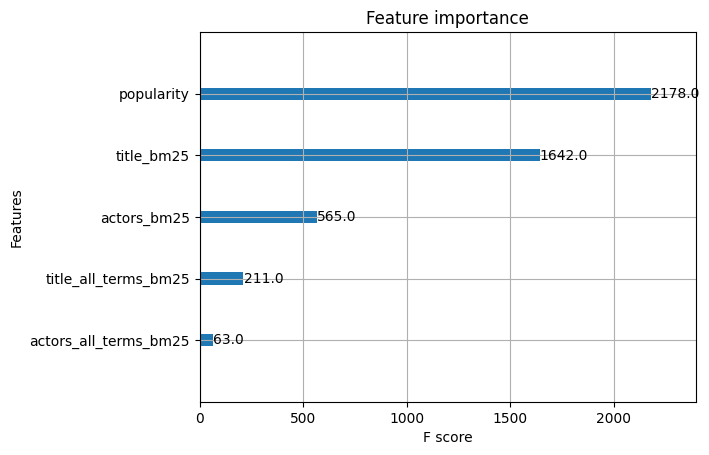

In [38]:
from xgboost import plot_importance

plot_importance(ranker, importance_type="weight");

## Import the model into Elasticsearch

Once the model is trained we can use Eland to load it into Elasticsearch.

Please note that the `MLModel.import_ltr_model` method contains the `LTRModelConfig` object which defines how features should be extracted for the model being imported.

In [39]:
from eland.ml import MLModel

LEARNING_TO_RANK_MODEL_ID = "ltr-model-xgboost"

MLModel.import_ltr_model(
    es_client=es_client,
    model=ranker,
    model_id=LEARNING_TO_RANK_MODEL_ID,
    ltr_model_config=ltr_config,
    es_if_exists="replace",
)

## Using the rescorer

Once the model is uploaded to Elasticsearch, you will be able to use it as a rescorer in the _search API, as shown in this example:

```
GET /movies/_search
{
   "query" : {
      "multi_match" : {
         "query": "star wars",
         "fields": ["title", "overview", "actors", "director", "tags", "characters"]
      }
   },
   "rescore" : {
      "window_size" : 50,
      "learning_to_rank" : {
         "model_id": "ltr-model-xgboost",
         "params": { 
            "query": "star wars"
         }
      }
   }
}
```

In [40]:
query = "star wars"

# First let's display the result when not using the rescorer:
search_fields = ["title", "overview", "actors", "director", "tags", "characters"]
bm25_query = {"multi_match": {"query": query, "fields": search_fields}}

bm25_search_response = es_client.search(index=MOVIE_INDEX, query=bm25_query)

[
    (movie["_source"]["title"], movie["_score"], movie["_id"])
    for movie in bm25_search_response["hits"]["hits"]
]

[('Star Wars', 10.971989, '11'),
 ('Star Wars: The Clone Wars', 9.923633, '12180'),
 ('Andor: A Disney+ Day Special Look', 8.9880295, '1022100'),
 ("Family Guy Presents: It's a Trap!", 8.845748, '278427'),
 ('Star Wars: The Rise of Skywalker', 8.053349, '181812'),
 ('Star Wars: The Force Awakens', 8.053349, '140607'),
 ('Star Wars: The Last Jedi', 8.053349, '181808'),
 ('Solo: A Star Wars Story', 8.053349, '348350'),
 ('The Star Wars Holiday Special', 8.053349, '74849'),
 ('Phineas and Ferb: Star Wars', 8.053349, '392216')]

In [41]:
# Now let's display result when using the rescorer:

ltr_rescorer = {
    "learning_to_rank": {
        "model_id": LEARNING_TO_RANK_MODEL_ID,
        "params": {"query": query},
    },
    "window_size": 100,
}

rescored_search_response = es_client.search(
    index=MOVIE_INDEX, query=bm25_query, rescore=ltr_rescorer
)

[
    (movie["_source"]["title"], movie["_score"], movie["_id"])
    for movie in rescored_search_response["hits"]["hits"]
]

[('Star Wars', 4.1874104, '11'),
 ('Star Wars: The Clone Wars', 2.3627238, '12180'),
 ('Star Wars: The Rise of Skywalker', 1.7667875, '181812'),
 ('Star Wars: The Force Awakens', 1.3336482, '140607'),
 ('Star Wars: The Last Jedi', 1.3336482, '181808'),
 ('Rogue One: A Star Wars Story', 1.1134433, '330459'),
 ('LEGO Star Wars Summer Vacation', 1.082971, '980804'),
 ("Doraemon: Nobita's Little Star Wars 2021", 0.9138395, '782054'),
 ('LEGO Star Wars Terrifying Tales', 0.89640737, '857702'),
 ('Solo: A Star Wars Story', 0.65811557, '348350')]

As also shown in the feature importance graph above, we can see in this results list that the `title_bm25` and `popularity` features are weighted highly in our trained model. Now all results include the query terms in the title, showing the importance of the `title_bm25` feature. Similarly, more popular movies now rank higher, for example `Rogue One: A Star Wars Story` is now in sixth position.